# Spatial Gaussian Process inference in PyMC3
This is the first step in modelling Species occurrence. 
The good news is that MCMC works,
The bad one is that it's computationally intense.


In [10]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps/external_plugins/spystats/')
#import django
#django.setup()
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')
import numpy as np

In [11]:
## Model Specification
import pymc3 as pm
from spystats import tools

## Simulated gaussian data


In [12]:
sigma=3.5
range_a=10.13
kappa=3.0/2.0
#ls = 0.2
#tau = 2.0
cov = sigma * pm.gp.cov.Matern32(2, range_a,active_dims=[0,1])


In [13]:
n = 10
grid = tools.createGrid(grid_sizex=n,grid_sizey=n,minx=0,miny=0,maxx=50,maxy=50)

In [14]:
K = cov(grid[['Lon','Lat']].values).eval()
sample = pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=1)
grid['Z'] = sample

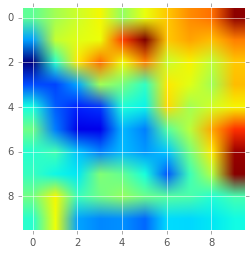

In [15]:
plt.figure(figsize=(14,4))
plt.imshow(grid.Z.values.reshape(n,n),interpolation=None)

In [16]:
print("sigma: %s, phi: %s"%(sigma,range_a))


sigma: 3.5, phi: 10.13


In [18]:
## Analysis, GP only one parameter to fit
# The variational method is much beter.
with pm.Model() as model:
    
    #sigma = 1.0
    sigma = pm.Uniform('sigma',0,4)
    phi = pm.Normal('phi',mu=8,sd=3)
#    phi = pm.Uniform('phi',5,10)

    cov = sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1])
    K = cov(grid[['Lon','Lat']].values)
    y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)
    
    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #ess_Step = pm.HamiltonianMC()
    #%time trace = pm.sample(5000)
    ## Variational
    %time results = pm.fit()
                    



Average Loss = 139.51: 100%|██████████| 10000/10000 [00:28<00:00, 348.57it/s]

CPU times: user 1min 36s, sys: 2.14 s, total: 1min 39s
Wall time: 30.6 s


## Diagnostics
For one parameter it took around 1.3 minutes
For two parameters it took 4min 27 seconds

In [19]:
from pymc3 import find_MAP
map_estimate = find_MAP(model=model)

logp = -139.58, ||grad|| = 2.6669e-05: 100%|██████████| 12/12 [00:00<00:00, 341.72it/s]  


## Simulated Poisson data with latent Gaussian Field

sigma: 3.5, phi: 10.13


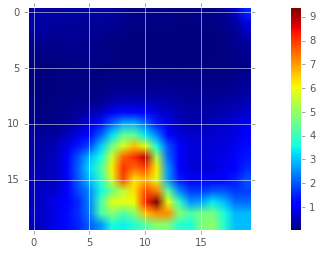

In [20]:
np.random.seed(1234)

sigma=3.5
range_a=10.13
kappa=3.0/2.0
#ls = 0.2
alpha = 0.0
cov = sigma * pm.gp.cov.Matern32(2, range_a,active_dims=[0,1])
n = 20
grid = tools.createGrid(grid_sizex=n,grid_sizey=n,minx=0,miny=0,maxx=20,maxy=20)
K = cov(grid[['Lon','Lat']].values).eval()
pfield = pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=1)

poiss_data = np.exp(alpha + pfield)

grid['Z'] = poiss_data
#grid['Z'] = pfield
plt.figure(figsize=(14,4))
plt.imshow(grid.Z.values.reshape(n,n),interpolation=None)
plt.colorbar()
print("sigma: %s, phi: %s"%(sigma,range_a))

In [21]:
## Analysis, GP only one parameter to fit
# The variational method is much beter.
from pymc3.variational.callbacks import CheckParametersConvergence

with pm.Model() as model:
    sigma=3.5
    range_a=10.13
    
    
    #sigma = pm.Uniform('sigma',0,4)
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',5,15)
    cov = sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1])
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(phi)
    
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    
    ## I don't know why this
    f = gp.prior("latent_field", X=grid[['Lon','Lat']].values,reparameterize=True)
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Poisson('y_obs',mu=f,observed=grid.Z)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)
    
    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()])
                    



Average Loss = inf: 100%|██████████| 10000/10000 [03:30<00:00, 47.47it/s]

CPU times: user 12min 55s, sys: 12.9 s, total: 13min 8s
Wall time: 3min 32s


ESsta dando un monton de inf en averafe lost

In [22]:
# pm.traceplot(trace)

In [23]:
#for RV in model.basic_RVs:
#    print(RV.name, RV.logp(model.test_point))

In [24]:
from pymc3 import find_MAP
map_estimate = find_MAP(model=model)
map_estimate

logp = -inf, ||grad|| = 214.35: 100%|██████████| 3/3 [00:00<00:00, 52.60it/s]


{'latent_field': array([-0.3834217 , -0.41007374, -0.43583168, -0.4601648 , -0.4825283 ,
        -0.50238856, -0.51925151, -0.53269178, -0.54237913, -0.54809885,
        -0.54976291, -0.54741049, -0.54119765, -0.53137821, -0.51827874,
        -0.502271  , -0.48374474, -0.46308261, -0.44063796, -0.41671505,
        -0.42857215, -0.45936469, -0.48921593, -0.51749078, -0.54353027,
        -0.56668294, -0.58634113, -0.6019791 , -0.61318854, -0.61970607,
        -0.6214286 , -0.61841367, -0.61086516, -0.59910711, -0.58355045,
        -0.56465742, -0.54290813, -0.51877131, -0.49268106, -0.46502698,
        -0.4771009 , -0.51254917, -0.54702953, -0.57978574, -0.61002385,
        -0.63695061, -0.65981963, -0.67798131, -0.69093038, -0.69834355,
        -0.70010052, -0.69628413, -0.68716007, -0.67314079, -0.65474072,
        -0.63253056, -0.60709641, -0.57900781, -0.54879816, -0.51696759,
        -0.52875988, -0.56939683, -0.60906844, -0.64687973, -0.68187894,
        -0.71310384, -0.73963986, -

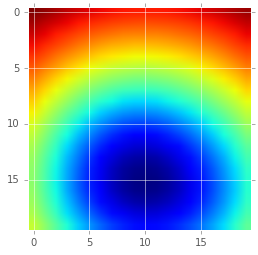

In [87]:
plt.imshow(map_estimate['latent_field'].reshape(20,20))

In [26]:
pm.plot_posterior(mean_field.sample(10), color='LightSeaGreen');

## Examine actual posterior distribution

The posterior is analytically tractable so we can compute the posterior mean explicitly. Rather than computing the inverse of the covariance matrix K, we use the numerically stable calculation described Algorithm 2.1 in the book “Gaussian Processes for Machine Learning” (2006) by Rasmussen and Williams, which is available online for free.

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, f, s=40, color='b', label='True points');

# Analytically compute posterior mean
## This is the cholesky decomposition of the Covariance Matrix with kernel nugget
L = np.linalg.cholesky(K_noise.eval())
## Faith step, This solves the base x's such that Lx = f and the uses x for solving y's such that L.T y = x
alpha = np.linalg.solve(L.T, np.linalg.solve(L, f))
## Multiply the posterior (ALgorithm 2.1 in Rasmunssen)
## Using the "extended matrix" K_s
post_mean = np.dot(K_s.T.eval(), alpha)

ax.plot(X0, post_mean, color='g', alpha=0.8, label='Posterior mean');

ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);
ax.legend();

Ok, it's good to have the analitical solution but not always possible sooooo.
Let's do some computing.
## Model in PyM3

In [ ]:
with pm.Model() as model:
    # The actual distribution of f_sample doesn't matter as long as the shape is right since it's only used
    # as a dummy variable for slice sampling with the given prior
    ### From doc:
    ### 
    
    
    
    f_sample = pm.Flat('f_sample', shape=(n, ))

    ## Actually, pm.Flat is a zero array of shape n
    # Likelihood
    ## The covariance is only in the diagonal
    
    y = pm.MvNormal('y', observed=sample, mu=f_sample, cov=noise * tt.eye(n), shape=n)

    # Interpolate function values using noisy covariance matrix
    ## Deterministic allows to compose (do algebra) with RV in many different ways. 
    ##While these transformations work seamlessly, its results are not stored automatically. 
    ##Thus, if you want to keep track of a transformed variable, you have to use pm.Determinstic:
    ## from http://docs.pymc.io/notebooks/api_quickstart.html
    
    ## So in this case is transforming the rv into:
    ## the low triangular cholesky decomposition of the Covariance with nugget
    L = tt.slinalg.cholesky(K_noise)
    ## So this is for calculating the "kernel" part of the MVN i.e. (mu -x).T * (LL.T)^-1 * (mu-x)
    ## but considering mu = 0 we have that x = linalg.solve(L,y) (because Lx = y)
    ## Then, L.T*x)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_sample))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(5000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

## Evaluate posterior fit

The posterior samples are consistent with the analytically derived posterior and behaves how one would expect–narrower near areas with lots of observations and wider in areas with more uncertainty.

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X0, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(X0, f, s=40, color='k', label='True points');
ax.plot(X0, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend();
ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);

In [ ]:
pm.traceplot(trace)

# Clasification
In Gaussian process classification, the likelihood is not normal and thus the posterior is not analytically tractable. The prior is again a multivariate normal with covariance matrix K, and the likelihood is the standard likelihood for logistic regression:
\begin{equation}
L(y | f) = \Pi_n \sigma(y_n, f_n)
\end{equation}

## Generate some example data

We generate random samples from a Gaussian process, assign any points greater than zero to a “positive” class, and assign all other points to a “negative” class.

In [ ]:
np.random.seed(5)
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_stable.eval())

# Separate data into positive and negative classes
f[f > 0] = 1
f[f <= 0] = 0

fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(X0, f, s=40, color='k', label='True points');
ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend();
ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);



## Sample from posterior distribution

In [ ]:
with pm.Model() as model:
    # Again, f_sample is just a dummy variable
    f_sample = pm.Flat('f_sample', shape=n)
    f_transform = pm.invlogit(f_sample)

    # Binomial likelihood
    y = pm.Binomial('y', observed=f, n=np.ones(n), p=f_transform, shape=n)

    # Interpolate function values using noiseless covariance matrix
    L = tt.slinalg.cholesky(K_stable)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_transform))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(5000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

## Evaluate posterior fit

The posterior looks good, though the fit is, unsurprisingly, erratic outside the range of the observed data.

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.04, color='navy')
ax.scatter(X0, f, s=40, color='k');
ax.set_xlim(0, 3);
ax.set_ylim(-0.1, 1.1);